## **Feature:** Crane Compliance Feature

**Names:** Tasveer Mann

### **What it does**
-  Detect missed prestarts, roster mismatches, streaks

-  Rank vehicles by risk (last 14 days)

-  Export daily compliance + risk CSVs

-  Optional: agentic run with graceful fallback

In [1]:
from pathlib import Path
from dotenv import load_dotenv
import os

# 1) Show where we and what files exist
CWD = Path.cwd()
print("CWD:", CWD)
print("Here:", [p.name for p in CWD.iterdir()])

# 2) Try the common locations (current dir and parent dir)
candidates = [CWD/"env.txt", CWD/".env", CWD.parent/"env.txt", CWD.parent/".env"]
print("Candidates:")
for p in candidates:
    print(" -", p, "exists?" , p.exists())

# 3) Load the first one force override in case)
loaded = False
for p in candidates:
    if p.exists():
        load_dotenv(p, override=True)
        loaded = True
        print("Loaded:", p)
        break

print("API key found?", bool(os.environ.get("OPENAI_API_KEY")))


# Core libs
import pandas as pd
import numpy as np
import re
import datetime

# LangChain (for the agentic part)
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage, SystemMessage

# ✅ Global LLM (agentic AI part) using the API key
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    api_key=os.environ.get("OPENAI_API_KEY")
)



CWD: /Users/tasmac/Data-Cleaning-Agent_Workshop-Version/features
Here: ['missing_vals.ipynb', 'summaries.ipynb', '.ipynb_checkpoints', 'feature_scaffold.ipynb', 'lv_compliance.ipynb']
Candidates:
 - /Users/tasmac/Data-Cleaning-Agent_Workshop-Version/features/env.txt exists? False
 - /Users/tasmac/Data-Cleaning-Agent_Workshop-Version/features/.env exists? False
 - /Users/tasmac/Data-Cleaning-Agent_Workshop-Version/env.txt exists? True
 - /Users/tasmac/Data-Cleaning-Agent_Workshop-Version/.env exists? True
Loaded: /Users/tasmac/Data-Cleaning-Agent_Workshop-Version/env.txt
API key found? True


### **Helper Functions**
[List Helper Functions]
- `helper_function_1(df,param=None)`: helper function 1 description
- `helper_function_2(series,method=None)`: helper function 2 description

In [2]:
def make_daily_compliance(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Return (daily_summary, df_with_flags)."""
    work = df.copy()

    # Parse dates/times
    work["date_only"]   = pd.to_datetime(work.get("Date2"), errors="coerce")
    work["prestart_ts"] = pd.to_datetime(work.get("ADJUSTED UTC 8 TIME"), errors="coerce", dayfirst=True)

    # Clean names
    def clean_name(x: str) -> str:
        if pd.isna(x): return ""
        x = str(x).strip()
        if x.startswith("? No Pre-start"): return ""
        if re.fullmatch(r"0/0?1/1900\s*0:00", x, flags=re.IGNORECASE): return ""
        return re.sub(r"\s+", " ", x)

    work["status_name"]   = work.get("Status", "").map(clean_name)
    work["forecast_name"] = work.get("Forecasted LV", pd.Series(index=work.index)).fillna("").astype(str).str.strip().replace("", np.nan)

    # Per-LV-per-day summary
    grp = work.sort_values("prestart_ts").groupby(["LV","date_only"], dropna=False)
    daily = grp.agg(
        prestart_done=("status_name", lambda s: s.str.len().gt(0).any()),
        prestart_by_first=("status_name", lambda s: next((x for x in s if x), "")),
        prestart_time_first=("prestart_ts", "min"),
        roster_any=("forecast_name", lambda s: s.notna().any()),
        roster_first=("forecast_name", lambda s: next((x for x in s if pd.notna(x)), np.nan)),
        rows=("LV","size"),
    ).reset_index()

    # Flags and notes
    daily["flag_no_prestart"] = ~daily["prestart_done"]
    daily["flag_roster_mismatch"] = (
        daily["prestart_done"] & daily["roster_any"] &
        (daily["prestart_by_first"].str.lower().fillna("") != daily["roster_first"].str.lower().fillna(""))
    )

    def build_note(r):
        msgs = []
        if r["flag_no_prestart"]:
            msgs.append("No prestart recorded.")
        if r["flag_roster_mismatch"]:
            msgs.append(f"Rostered '{r['roster_first']}' but prestart by '{r['prestart_by_first']}'.")
        return "; ".join(msgs)
    daily["notes"] = daily.apply(build_note, axis=1)

    # Attach flags back to raw rows
    df_out = work.merge(
        daily[["LV","date_only","flag_no_prestart","flag_roster_mismatch","prestart_by_first","prestart_time_first","roster_first","notes"]],
        on=["LV","date_only"], how="left"
    )

    return daily.sort_values(["date_only","LV"]).reset_index(drop=True), df_out


In [3]:
from datetime import timedelta

def compute_risk(daily: pd.DataFrame, window_days: int = 14, today: pd.Timestamp | None = None) -> pd.DataFrame:
    """
    Score per LV over a recent window:
      +2 for each no-prestart day
      +1 for each roster mismatch day
      +1 bonus if 3+ consecutive no-prestart days exist
    """
    if today is None:
        today = pd.to_datetime(daily["date_only"].max())
    start = today - timedelta(days=window_days-1)
    recent = daily[(daily["date_only"] >= start) & (daily["date_only"] <= today)].copy()

    recent["score"] = recent["flag_no_prestart"].astype(int)*2 + recent["flag_roster_mismatch"].astype(int)

    def streak_bonus(df_lv):
        df_lv = df_lv.sort_values("date_only")
        streak = max_streak = 0
        for missed in df_lv["flag_no_prestart"]:
            streak = streak + 1 if missed else 0
            max_streak = max(max_streak, streak)
        return 1 if max_streak >= 3 else 0

    bonus = (
    recent.groupby("LV", group_keys=False)[["date_only", "flag_no_prestart"]]
          .apply(streak_bonus)
          .rename("streak_bonus")
          .reset_index()
    )


    agg = recent.groupby("LV", as_index=False).agg(
        days=("date_only","nunique"),
        no_prestart_days=("flag_no_prestart","sum"),
        mismatch_days=("flag_roster_mismatch","sum"),
        base_score=("score","sum"),
    )
    out = agg.merge(bonus, on="LV", how="left")
    out["risk_score"] = out["base_score"] + out["streak_bonus"]
    out["window"] = f"{start.date()} → {today.date()}"
    return out.sort_values(["risk_score","no_prestart_days","mismatch_days"], ascending=[False, False, False]).reset_index(drop=True)


In [4]:
helper_docs = """
Helper functions:
- make_daily_compliance(df): returns (daily_summary, df_with_flags)
- compute_risk(daily, window_days=14): top risk last N days

Rules for the agent:
- Assume df is defined
- Prefer helper functions
- Use print() to explain steps and counts
- No imports
"""


# **MAIN FEATURE FUNCTION**

In [5]:
def feature_function(df, user_query):
    """
    Main function that gets called by the main router.
    MUST take (user_query, df) and return df
    """

    # --- Build prompt for the agent ---
    messages = []
    messages.append(SystemMessage(content=helper_docs))
    messages.append(SystemMessage(content=f"""
You are a data cleaning agent.

Dataset info: Shape: {df.shape}, Sample: {df.head(3).to_string()}

Libraries available:
- pd (pandas), np (numpy)
- math, re, datetime

Rules:
- Return only executable Python code, no explanations, no markdown blocks
- Use helper functions if needed
- ASSUME "df" IS ALREADY DEFINED
- In order to generate a response/message to the user use print statements  print("message")
- Write a detailed print message to summarise actions taken and reasons
"""))
    messages.append(HumanMessage(content=f"User request: {user_query}"))

    # --- Call the global LLM (already configured with API key) ---
    generated_code = None
    try:
        response = llm.invoke(messages)   # <- use the global llm defined in the imports cell
        generated_code = response.content.strip()
    except Exception as api_error:
        # --- If LLM call failed, run a rock-solid local fallback so your demo still wins ---
        print(f"[Agent fallback] LLM unavailable or auth failed: {api_error}")
        print("Running built-in pipeline: make_daily_compliance + compute_risk + CSV export")
        daily, df_flagged = make_daily_compliance(df)
        risk = compute_risk(daily, window_days=14)

        # Clear, judge-friendly summary
        print("\n=== Compliance Overview ===")
        print(f"Vehicles: {daily['LV'].nunique()}  |  Days: {daily['date_only'].nunique()}")
        print(f"No-prestart days: {int(daily['flag_no_prestart'].sum())}")
        print(f"Roster mismatches: {int(daily['flag_roster_mismatch'].sum())}")

        # Export artifacts
        from pathlib import Path
        import pandas as pd
        outdir = "../outputs"
        Path(outdir).mkdir(parents=True, exist_ok=True)
        ts = pd.Timestamp.now().strftime("%Y%m%d-%H%M")
        daily_path = f"{outdir}/daily_compliance_{ts}.csv"
        risk_path  = f"{outdir}/risk_{ts}.csv"
        daily.to_csv(daily_path, index=False, encoding="utf-8")
        risk.to_csv(risk_path, index=False, encoding="utf-8")
        print("Saved:")
        print("-", daily_path)
        print("-", risk_path)

        # Return something useful to the router (original contract is "return df")
        return df_flagged

    # --- If we have generated code, execute it safely on a copy ---
    try:
        original_df = df.copy()
        exec(generated_code)
        return df
    except Exception as e:
        print(f"[Agent error] {e}")
        print("Generated Code:\n", generated_code)
        return original_df



# **Testing**

In [6]:
# Load full dataset (exported from Numbers, defaults to UTF-8)
df = pd.read_csv("../datasets/lv_compliance_cranes.csv")

# Parse proper date column
df["date_only"] = pd.to_datetime(df["Date2"], errors="coerce")

print("Full dataset shape:", df.shape)
print("Columns:", list(df.columns))
display(df.head())


Full dataset shape: (16356, 9)
Columns: ['LV', 'SPEED', 'DATE', 'Date2', 'Status', 'Prestart ID', 'Forecasted LV', 'ADJUSTED UTC 8 TIME', 'date_only']


,LV,SPEED,DATE,Date2,Status,Prestart ID,Forecasted LV,ADJUSTED UTC 8 TIME,date_only
0,NCH 70,1,14/09/2025 3:59,2025/09/14,? No Pre-start,NCH 702025/09/14,NaN,14/09/2025 11:59,2025-09-14
1,NCH 70,1,14/09/2025 3:40,2025/09/14,? No Pre-start,NCH 702025/09/14,NaN,14/09/2025 11:40,2025-09-14
2,NCH 56,1,14/09/2025 3:35,2025/09/14,? No Pre-start,NCH 562025/09/14,NaN,14/09/2025 11:35,2025-09-14
3,NCH 54,1,14/09/2025 3:33,2025/09/14,? No Pre-start,NCH 542025/09/14,NaN,14/09/2025 11:33,2025-09-14
4,NCH 70,1,14/09/2025 3:28,2025/09/14,? No Pre-start,NCH 702025/09/14,NaN,14/09/2025 11:28,2025-09-14


In [7]:
# Categorize status into buckets
def categorize_status(s):
    s = str(s).strip().lower()
    if "no pre" in s:
        return "no_prestart"
    elif s.startswith("0/01/1900") or s == "nan" or s == "":
        return "junk"
    else:
        return "valid_name"

df["status_type"] = df["Status"].apply(categorize_status)

# Aggregate by date
daily_counts = df.groupby("date_only")["status_type"].value_counts().unstack(fill_value=0)

# Sliding 14-day window sums
rolling_window = daily_counts.rolling("14D", min_periods=7).sum()

# Pick the most "interesting" slice
best_end_date = rolling_window["no_prestart"].add(
    rolling_window.get("junk", 0)
).add(
    rolling_window.get("valid_name", 0).clip(upper=50)
).idxmax()
best_start_date = best_end_date - pd.Timedelta(days=13)

print("Best demo window:", best_start_date.date(), "→", best_end_date.date())


Best demo window: 2025-07-29 → 2025-08-11


In [8]:
# Filter dataset to the demo window
demo_df = df[df["date_only"].between(best_start_date, best_end_date)].copy()

print("Demo slice:", demo_df["date_only"].min(), "→", demo_df["date_only"].max())
print("Rows:", demo_df.shape[0], "| Vehicles:", demo_df["LV"].nunique())

# Build compliance + risk tables for demo slice
daily, flagged = make_daily_compliance(demo_df)
risk = compute_risk(daily, window_days=14)

print("\n=== Daily Compliance Summary (Demo Window) ===")
print(daily.head())

print("\n=== Risk Table (Demo Window) ===")
print(risk.head(10))


Demo slice: 2025-07-29 00:00:00 → 2025-08-11 00:00:00
Rows: 4184 | Vehicles: 28

=== Daily Compliance Summary (Demo Window) ===
       LV  date_only  prestart_done prestart_by_first prestart_time_first  \
0  NCH 28 2025-07-29           True     Wayne Daniels 2025-07-29 05:34:00   
1  NCH 31 2025-07-29           True         Stu Kingi 2025-07-29 06:22:00   
2  NCH 35 2025-07-29          False                   2025-07-29 00:17:00   
3  NCH 36 2025-07-29           True   Jamie Parkinson 2025-07-29 10:35:00   
4  NCH 37 2025-07-29          False                   2025-07-29 00:02:00   

   roster_any roster_first  rows  flag_no_prestart  flag_roster_mismatch  \
0       False          NaN     5             False                 False   
1        True    Stu Kingi    12             False                 False   
2       False          NaN    16              True                 False   
3        True      Jamie P     7             False                  True   
4       False          NaN   

### Daily Compliance (Code)

In [9]:
daily, df_flagged = make_daily_compliance(demo_df)
print("=== Daily Compliance Summary ===")
daily.head(10)

=== Daily Compliance Summary ===


,LV,date_only,prestart_done,prestart_by_first,prestart_time_first,roster_any,roster_first,rows,flag_no_prestart,flag_roster_mismatch,notes
0,NCH 28,2025-07-29,True,Wayne Daniels,2025-07-29 05:34:00,False,NaN,5,False,False,
1,NCH 31,2025-07-29,True,Stu Kingi,2025-07-29 06:22:00,True,Stu Kingi,12,False,False,
2,NCH 35,2025-07-29,False,,2025-07-29 00:17:00,False,NaN,16,True,False,No prestart recorded.
3,NCH 36,2025-07-29,True,Jamie Parkinson,2025-07-29 10:35:00,True,Jamie P,7,False,True,Rostered 'Jamie P' but prestart by 'Jamie Park...
4,NCH 37,2025-07-29,False,,2025-07-29 00:02:00,False,NaN,23,True,False,No prestart recorded.
5,NCH 38,2025-07-29,False,,2025-07-29 06:09:00,True,R&M,2,True,False,No prestart recorded.
6,NCH 39,2025-07-29,True,Rangi Abbot,2025-07-29 02:01:00,True,Rangi,13,False,True,Rostered 'Rangi' but prestart by 'Rangi Abbot'.
7,NCH 40,2025-07-29,True,Paul Smeaton,2025-07-29 00:12:00,True,Paul Smeaton,12,False,False,
8,NCH 41,2025-07-29,True,Philip Dolan,2025-07-29 07:41:00,True,Phil Dolan,8,False,True,Rostered 'Phil Dolan' but prestart by 'Philip ...
9,NCH 42,2025-07-29,True,Curtis Weeks,2025-07-29 00:08:00,True,Curtis Week,12,False,True,Rostered 'Curtis Week' but prestart by 'Curtis...


### Summary Counts + Risk Table (Code)

#### Cell A — counts + risk:

In [10]:
# Counts for the whole dataset
print("=== Summary (whole dataset) ===")
print("Vehicles:", daily["LV"].nunique(), "| Days:", daily["date_only"].nunique())
print("No-prestart days:", int(daily["flag_no_prestart"].sum()))
print("Roster mismatch days:", int(daily["flag_roster_mismatch"].sum()))

# Risk table (wow factor)
risk = compute_risk(daily, window_days=14)
print("\n=== Top 10 Risk Vehicles (last 14 days) ===")
print(risk.head(10))

try:
    display(risk.head(10).style.hide(axis="index"))
except Exception:
    print(risk.head(10))


=== Summary (whole dataset) ===
Vehicles: 28 | Days: 14
No-prestart days: 201
Roster mismatch days: 63

=== Top 10 Risk Vehicles (last 14 days) ===
       LV  days  no_prestart_days  mismatch_days  base_score  streak_bonus  \
0  NCH 45    14                14              0          28             1   
1  NCH 61    14                13              1          27             1   
2  NCH 46    14                13              0          26             1   
3  NCH 55    14                12              2          26             1   
4  NCH 56    14                11              1          23             1   
5  NCH 38    11                11              0          22             1   
6  NCH 71    14                10              1          21             1   
7  NCH 64    12                 9              3          21             1   
8  NCH 52    12                10              0          20             1   
9  NCH 44    14                 9              2          20            

LV,days,no_prestart_days,mismatch_days,base_score,streak_bonus,risk_score,window
NCH 45,14,14,0,28,1,29,2025-07-29 → 2025-08-11
NCH 61,14,13,1,27,1,28,2025-07-29 → 2025-08-11
NCH 46,14,13,0,26,1,27,2025-07-29 → 2025-08-11
NCH 55,14,12,2,26,1,27,2025-07-29 → 2025-08-11
NCH 56,14,11,1,23,1,24,2025-07-29 → 2025-08-11
NCH 38,11,11,0,22,1,23,2025-07-29 → 2025-08-11
NCH 71,14,10,1,21,1,22,2025-07-29 → 2025-08-11
NCH 64,12,9,3,21,1,22,2025-07-29 → 2025-08-11
NCH 52,12,10,0,20,1,21,2025-07-29 → 2025-08-11
NCH 44,14,9,2,20,1,21,2025-07-29 → 2025-08-11


#### Cell B — exports

In [11]:
ts = pd.Timestamp.now().strftime("%Y%m%d-%H%M")
outdir = Path("../outputs"); outdir.mkdir(parents=True, exist_ok=True)
daily_path = outdir / f"daily_compliance_{ts}.csv"
risk_path  = outdir / f"risk_{ts}.csv"
daily.to_csv(daily_path, index=False, encoding="utf-8")
risk.to_csv(risk_path, index=False, encoding="utf-8")
print("Saved:"); print("-", daily_path); print("-", risk_path)


Saved:
- ../outputs/daily_compliance_20250915-1109.csv
- ../outputs/risk_20250915-1109.csv


### Visuals (Code)

#### Cell A — trend line

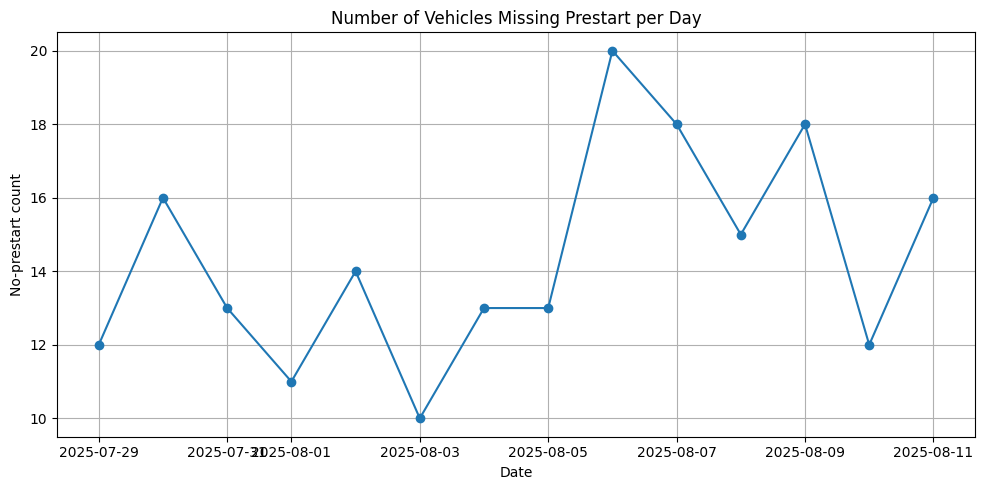

In [12]:
import matplotlib.pyplot as plt

trend = daily.groupby("date_only")["flag_no_prestart"].sum().sort_index()
plt.figure(figsize=(10,5))
plt.plot(trend.index, trend.values, marker="o")
plt.title("Number of Vehicles Missing Prestart per Day")
plt.xlabel("Date"); plt.ylabel("No-prestart count")
plt.grid(True); plt.tight_layout(); plt.show()


##### *This chart shows fluctuations in compliance over time, highlighting days where no-prestarts were frequent.*

#### Cell B — risk bar chart

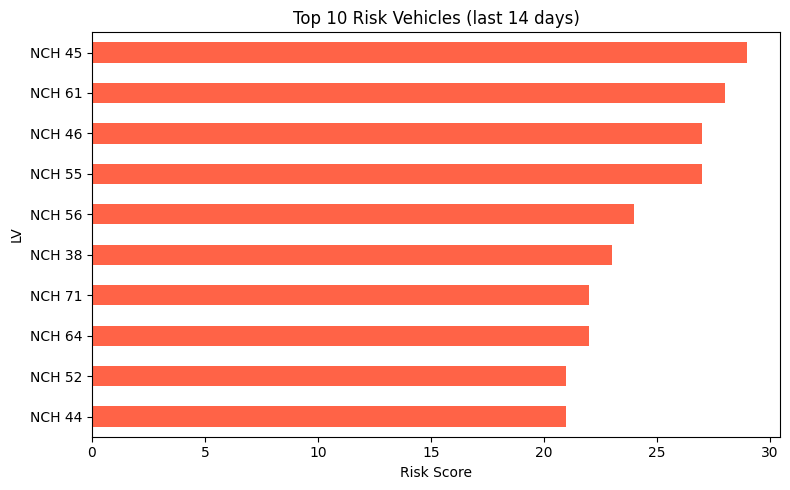

In [13]:
import matplotlib.pyplot as plt


top10 = risk.head(10).set_index("LV")
ax = top10["risk_score"].plot(kind="barh", figsize=(8,5), color="tomato")
plt.title("Top 10 Risk Vehicles (last 14 days)")
plt.xlabel("Risk Score"); plt.ylabel("LV")
plt.gca().invert_yaxis()
plt.tight_layout(); plt.show()

##### *This bar chart highlights the vehicles most at risk of repeated non-compliance.*

##### **How to read this:** higher bars = more repeated non-compliance (no-prestarts, mismatches, and streaks). This ranks where supervisors should focus first.

In [14]:
feature_function(
    demo_df,
    "Give me a daily compliance summary, then show how many vehicles had no prestart or mismatches, and finally rank the top 10 riskiest vehicles"
)


Daily compliance summary has been generated.
Summary shape: (347, 11)
Number of vehicles with no prestart: 2070
Number of vehicles with mismatches: 0
Top 10 riskiest vehicles have been ranked.
       LV  days  no_prestart_days  mismatch_days  base_score  streak_bonus  \
0  NCH 45    14                14              0          28             1   
1  NCH 61    14                13              1          27             1   
2  NCH 46    14                13              0          26             1   
3  NCH 55    14                12              2          26             1   
4  NCH 56    14                11              1          23             1   
5  NCH 38    11                11              0          22             1   
6  NCH 71    14                10              1          21             1   
7  NCH 64    12                 9              3          21             1   
8  NCH 52    12                10              0          20             1   
9  NCH 44    14            

,LV,SPEED,DATE,Date2,Status,Prestart ID,Forecasted LV,ADJUSTED UTC 8 TIME,date_only,status_type
7781,NCH 28,1,11/08/2025 15:45,2025/08/11,? No Pre-start,NCH 282025/08/11,Sean,11/08/2025 23:45,2025-08-11,no_prestart
7782,NCH 61,1,11/08/2025 15:42,2025/08/11,? No Pre-start,NCH 612025/08/11,NaN,11/08/2025 23:42,2025-08-11,no_prestart
7783,NCH 65,1,11/08/2025 15:26,2025/08/11,Rangi Abbot,NCH 652025/08/11,NaN,11/08/2025 23:26,2025-08-11,valid_name
7784,NCH 64,1,11/08/2025 15:25,2025/08/11,0/01/1900 0:00,NCH 642025/08/11,NaN,11/08/2025 23:25,2025-08-11,junk
7785,NCH 28,1,11/08/2025 14:45,2025/08/11,? No Pre-start,NCH 282025/08/11,Sean,11/08/2025 22:45,2025-08-11,no_prestart
...,...,...,...,...,...,...,...,...,...,...
11960,NCH 40,1,28/07/2025 16:12,2025/07/29,Paul Smeaton,NCH 402025/07/29,Paul Smeaton,29/07/2025 0:12,2025-07-29,valid_name
11961,NCH 37,1,28/07/2025 16:12,2025/07/29,0/01/1900 0:00,NCH 372025/07/29,NaN,29/07/2025 0:12,2025-07-29,junk
11962,NCH 70,1,28/07/2025 16:10,2025/07/29,? No Pre-start,NCH 702025/07/29,NaN,29/07/2025 0:10,2025-07-29,no_prestart
11963,NCH 42,1,28/07/2025 16:08,2025/07/29,Curtis Weeks,NCH 422025/07/29,Curtis Week,29/07/2025 0:08,2025-07-29,valid_name


## Next Steps  

**Embed in Dashboards:** Attach results to Power BI or Tableau to observe compliance, risk trends in real time.
-  **Push Alerts:** Push alerts through either Power Automate or triggers that send emails to supervisors when a vehicle either hits a "high risk" category.
-  **Additional Items:** Extend the analysis to using violations of speed, fatigue checks of the drivers, or maintenance compliance with roadside inspections.
-  **Streaming Services:** Switch from static CSV files to data streams with a focus on being proactive with scanning the compliance trends of a fleets.
-  **Scalability:** The same pipeline can be applied across multiple sites or fleets, to boil down to compliance performance benchmarking.
